In [1]:
#v1 修改时序上bug
#v2 增加边缘特征

import math
import random
import numpy as np
import pandas as pd

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import time

import collections
import copy

#env = gym.make('CartPole-v0').unwrapped

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# if gpu is to be used
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

import os
pathName = '/home/ubuntu/data/PEC/model_dict/ml100k/'
if not os.path.exists(pathName):
    os.makedirs(pathName)
MODELPATH = pathName + 'dnn_h0_v2.0_'

data_path = '/home/ubuntu/data/dataset/ml-100k/'
UIT = pd.read_csv(data_path + 'ml_header.trace')
simUsers = np.loadtxt(data_path+"simUser.csv",  delimiter=',',dtype=np.int)

trainUIT = UIT[UIT['day']<max(UIT['day']+1)*0.6]
validUIT = UIT[UIT['day']<max(UIT['day']+1)*0.8]

contentNum = len(UIT.i.drop_duplicates())
userNum = len(UIT.u.drop_duplicates())

rewardPara = {"alpha":0,"betao":1,"betal":1}
latency = [0.2,1,0.8]
Bu = 20

BATCH_SIZE = 128
#GAMMA = 0.99

num_episodes = 10
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = trainUIT.shape[0]*3
agentStep = 0

torch.cuda.empty_cache()


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','content'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self,inputs,outputs):
        super(DQN, self).__init__()
        self.conn1 = nn.Linear(inputs,32)
        self.conn2 = nn.Linear(32,128)
        self.conn3 = nn.Linear(128,16)
        self.conn4 = nn.Linear(16, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float().to(device)
        x = F.relu(self.conn1(x))
        x = F.relu(self.conn2(x))
        x = F.relu(self.conn3(x))
        return self.conn4(x)

In [3]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        #print(len(memory))
        return 0
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    content_batch = torch.cat(batch.content)
    next_state_batch = torch.cat(batch.next_state)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_mask_bacth = action_batch.ge(0.5)
    state_action_values = torch.stack(torch.masked_select(policy_net(state_batch),state_action_mask_bacth).chunk(BATCH_SIZE,dim=0)).sum(dim=1)
    
    #state_action_values = torch.stack((policy_net(state_batch).squeeze(1) * action_batch).chunk(BATCH_SIZE,dim=0)).sum(dim=1)

    #print(state_action_values,state_action_values.dtype)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    #next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    '''
    def getNextStatusQ(s_batch,c_batch):
        
        Q_value= torch.stack(target_net(s_batch).detach().chunk(BATCH_SIZE,dim=0))
        c = c_batch.chunk(BATCH_SIZE,dim=0)
        action = torch.zeros(size=(BATCH_SIZE,contentNum,2),dtype=int).to(device)
        for b in range(BATCH_SIZE):
            Q_value_sortindex = list((Q_value[b,:,1]-Q_value[b,:,0]).argsort(descending=True)[0:Bu])
            i = c[b].squeeze()
            if i not in Q_value_sortindex:
                Q_value_sortindex.pop()
            action[b,i,1] = 1
            for index in Q_value_sortindex:
                action[b,index,1] = 1
        action[:,:,0]=1-action[:,:,1]
        action_mask = action.ge(0.5).to(device)
        next_state_values = torch.stack(torch.masked_select(Q_value,action_mask).chunk(BATCH_SIZE,dim=0)).sum(dim=1).float()

        return next_state_values
    '''
    #next_state_values =  getNextStatusQ(next_state_batch,content_batch)

    # Compute the expected Q values
    #expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    expected_state_action_values =  reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values.unsqueeze(1), expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss


In [4]:
class ENV(object):
    def __init__(self,userNum,contentNum,latency,Bu):
        self.userNum = userNum
        self.contentNum =contentNum

        self.r = np.zeros(shape=(userNum,contentNum),dtype=int)
        self.p = np.full(shape=contentNum,fill_value = 1/userNum,dtype=np.float32)
        self.e = np.zeros(shape=contentNum,dtype=int)
        self.S = np.ones(shape=contentNum,dtype=int)
        self.l = np.array(latency,dtype=np.float32)
        

        self.B = np.full(shape=userNum,fill_value=Bu,dtype=int)

        self.pipe = collections.OrderedDict()


    #有序字典实现LRU
    def updateEgdeCache(self,action,t):
        for i in np.argwhere(action==1).squeeze(-1):
            if i in self.pipe.keys():
                self.pipe.pop(i)
            elif len(self.pipe) >= 500:
                self.e[self.pipe.popitem(last=False)[0]] = 0
            self.pipe[i] = t
            self.e[i] = 1

    
    def updateEnv(self,u,action,t):
        
        p_tmp = ((self.r[u] | action)-self.r[u])*(1/self.userNum) + self.p
        self.p = np.where(p_tmp<1-1/self.userNum,p_tmp,1-1/self.userNum)
        self.r[u] =  self.r[u] | action

        self.updateEgdeCache(action,t)

    def getStatus(self):
        return (self.r,
                self.p, 
                self.e,
                self.S,
                self.l)

    #def reset(self):
    #    self.r = np.zeros(shape=(self.userNum,self.contentNum),dtype=int)
    #    self.p = np.full(shape=self.contentNum,fill_value = 1/self.userNum)
    #    self.e = np.zeros(shape=self.contentNum)
    #    self.S = np.ones(shape=self.contentNum,dtype=int)
    #    self.l_edge = 0.1
    #    self.l_cp = 1
    #    self.B = np.full(shape=self.userNum,fill_value=15,dtype=int)
    #    self.pipe = collections.OrderedDict()

class UE(object):
    def __init__(self,u,env,rewardPara):
        self.u = u

        self.W = []
        self.v = np.zeros(contentNum,dtype=int)

        self.Bu = Bu
        self.contentNum = contentNum
        self.userNum = userNum

        r , p , e, S, l = env.getStatus()

        #self.lastAction = torch.zeros(size=(contentNum,),dtype=int)
        self.lastAction = np.zeros(contentNum,dtype=int)

        self.ALPHAh = rewardPara['alpha']
        self.BETAo =  rewardPara['betao']
        self.BETAl =  rewardPara['betal']             
        self.reward = 0

        self.simU = simUsers[u]
        self.lastStatusFeature = self.statusEmbedding(r,p,e)
        
        #self.lastp = p.clone()
        #self.lastp = p.copy()
        
        self.lastp = p
       # self.lastr = r.clone()
        #self.lastr = r.copy()
        self.lastru = r[self.u]
        
    def updateViewContent(self,i):
        self.W.append(i)
        self.v[i] = 1

    def statusEmbedding(self,r,p,e):
        tmp = np.zeros(contentNum,dtype=np.float32)
        for simUser in self.simU:
            tmp += r[simUser]
        simUserRu = (tmp / len(self.simU))
        ru = r[self.u]
        statusFeature = np.row_stack((self.v,ru,simUserRu,p,e))
        
        return statusFeature.T.astype(np.float32)
    
    def getReward(self,lastru,lastp,ru,p,i,lastAction,S,l,e,v):
        
        #self.Rh =   self.ALPHAh * (np.log(v * p + (1-v) * (1-p)).sum() / np.log(ru * p + (1-ru) * (1-p)).sum() )

        #self.Rh = self.ALPHAh * ( 1 / ( 1 + np.exp( 0.5 * np.log( ( lastru * lastp + ( 1 - lastru ) * ( 1 - lastp ) ) / ( ru * p + ( 1 - ru ) * ( 1 - p ) ) ).sum() ) ) )

        self.Rh = - self.ALPHAh * ( np.log( ( lastru * lastp + ( 1 - lastru ) * ( 1 - lastp ) ) / ( ru * p + ( 1 - ru ) * ( 1 - p ) ) ).sum() )


        self.Ro =   self.BETAo * lastAction[i] * S[i] * ( e[i] * l[0] + ( 1 - e[i] ) * l[1] )
        
        # self.Ro =   self.BETAo * lastAction[i] * S[i] * ( 1 + e[i] * l[0] + ( 1 - e[i] ) * l[1] )

        self.Rl =   self.BETAl * ( 1 - lastAction[i] ) * S[i] * e[i] * l[2]

        #self.Rh[i] = self.Rh[i] + self.Ro + self.Rl

        #return  self.Rh.sum()
        return  (self.Rh + self.Ro + self.Rl).astype(np.float32)

    def selectAction(self,env,uit,QNetwork,train,memory):
        
        self.updateViewContent(uit[1])
        
        r , p , e, S, l = env.getStatus()
        
        self.reward = self.getReward(self.lastru,self.lastp,r[self.u],p,self.W[-1],self.lastAction,S,l,e,self.v)

        self.lastp = p
        self.lastru = copy.copy(r[self.u])
        
        #self.lastp = p.clone()
        #self.lastr = r.clone()
        
        statusFeature = torch.from_numpy(self.statusEmbedding(r,p,e))
        
        if train and len(self.W)>1: #d
            lastAction = np.row_stack((1-self.lastAction,self.lastAction)).T
            #lastAction = self.lastAction
            memory.push(self.lastStatusFeature.to(device), 
                        torch.from_numpy(lastAction).to(device), 
                        statusFeature.to(device),
                        torch.tensor([self.reward]).to(device),
                        torch.tensor([self.W[-1]]).to(device))
        self.lastStatusFeature = statusFeature
        
        if self.W[-1] not in np.argwhere(self.lastAction): #local cache miss
            sample = random.random()
            eps_threshold = EPS_END + (EPS_START - EPS_END) *  np.exp(-1. * agentStep / EPS_DECAY)
            #eps_threshold = 0
            if  not train or (train and sample >= eps_threshold): #var greedy
                QNetwork.eval()
                #with torch.no_grad():
                Q_value = QNetwork(statusFeature).detach()
                QNetwork.train()
                actionIndex = list((Q_value[:,1]-Q_value[:,0]).argsort(descending=True)[0:self.Bu])
                
            else:
                actionIndex = list(torch.randint(0,self.contentNum,(self.Bu,)))
            action = np.zeros(contentNum,dtype=int)
            action[self.W[-1]] = 1
            if self.W[-1] not in actionIndex:
                actionIndex.pop()
            for index in actionIndex:
                action[index] = 1
            
            self.lastAction = action
            env.updateEnv(self.u,action,uit[2])
        else:
            action = self.lastAction # keep the cache and no request the new video
        return action


In [5]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
#init_screen = get_screen()
#_, _, screen_height, screen_width = init_screen.shape
# Get number of actions from gym action space
#n_actions = env.action_space.n
policy_net = DQN(5, 2).to(device)
target_net = DQN(5, 2).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(4000)
torch.cuda.empty_cache()

bestReward =  float("-inf")

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env = ENV(userNum,contentNum,latency,Bu)
    UEs = {}
    sumReward = np.zeros(3)
    loss = 0
    UEHit = np.zeros(userNum)
    edgeHit = 0
    for index,trace in trainUIT.iterrows():
        uit = trace.to_numpy()

        if uit[0] not in UEs:
            UEs[uit[0]] = UE(uit[0],env,rewardPara)
        ue = UEs[uit[0]]

        actionIndex = np.argwhere(ue.lastAction)
        if uit[1] in actionIndex:
            UEHit[uit[0]] += 1
        elif uit[1] in env.pipe.keys():
            edgeHit += 1

        ue.selectAction(env,uit,policy_net,1,memory)

        sumReward[0] += float(ue.Rh)
        sumReward[1] += float(ue.Ro)
        sumReward[2] += float(ue.Rl)
        agentStep += 1

        # train the DQN network
        if (index+1) % 10 == 0:
            # Perform one step of the optimization (on the policy network)
            loss += float(optimize_model())
            # Update the target network, copying all weights and biases in DQN
            target_net.load_state_dict(policy_net.state_dict())
        '''
        if (index+1) % 1000 == 0 :
            psi = 0
            for u in UEs:
                psi += np.log(env.r[u] * env.p + (1-env.r[u]) * (1-env.p)).sum() / np.log(UEs[u].v * env.p + (1-UEs[u].v) * (1-env.p)).sum()
            print("--Time:",time.asctime( time.localtime(time.time())),"  Index:",index,"  Loss:",round(loss/(index+1),5),"--")
            print("Reward:",np.around(sumReward/(index+1),5),"total reward:",round(sumReward.sum()/(index+1),5))
            print("UEHitrate:",round(UEHit.sum()/(index+1),5)," edgeHitrate",round(edgeHit/(index+1),5),"sumHitrate",round((edgeHit+UEHit.sum())/(index+1),5)," privacy:",round(float(psi)/len(UEs),5))
            print()
        '''
    psi = 0
    for u in UEs:
        psi += np.log(env.r[u] * env.p + (1-env.r[u]) * (1-env.p)).sum() / np.log(UEs[u].v * env.p + (1-UEs[u].v) * (1-env.p)).sum()
    print("------------------------------train----------------------------------")
    print("--Time:",time.asctime( time.localtime(time.time())),"Episode:",i_episode,"  Index:",index,"  Loss:",round(loss/(index+1),5),"--")
    print("Reward:",np.around(sumReward/(index+1),5),"total reward:",round(sumReward.sum()/(index+1),5))
    print("UEHitrate:",round(UEHit.sum()/(index+1),5)," edgeHitrate",round(edgeHit/(index+1),5),"sumHitrate",round((edgeHit+UEHit.sum())/(index+1),5)," privacy:",round(float(psi)/len(UEs),5))
    print("------------------------------train----------------------------------")
    print()
    # Update the target network, copying all weights and biases in DQN
    target_net.load_state_dict(policy_net.state_dict())
    
    #valid the hyperparameters
    env = ENV(userNum,contentNum,latency,Bu)
    UEs = {}
    sumReward = np.zeros(3)
    loss = 0
    UEHit = np.zeros(userNum)
    edgeHit = 0
    for index,trace in validUIT.iterrows():
        uit = trace.to_numpy()

        if uit[0] not in UEs:
            UEs[uit[0]] = UE(uit[0],env,rewardPara)
        ue = UEs[uit[0]]

        actionIndex = np.argwhere(ue.lastAction)
        if uit[1] in actionIndex:
            UEHit[uit[0]] += 1
        elif uit[1] in env.pipe.keys():
            edgeHit += 1

        ue.selectAction(env,uit,policy_net,0,memory)

        sumReward[0] += float(ue.Rh)
        sumReward[1] += float(ue.Ro)
        sumReward[2] += float(ue.Rl)       

    psi = 0
    for u in UEs:
        psi += np.log(env.r[u] * env.p + (1-env.r[u]) * (1-env.p)).sum() / np.log(UEs[u].v * env.p + (1-UEs[u].v) * (1-env.p)).sum()
    print("------------------------------validation---------------------------#-------")
    print("--Time:",time.asctime( time.localtime(time.time())),"Episode:",i_episode,"  Index:",index,"  Loss:",round(loss/(index+1),5),"--")
    print("Reward:",np.around(sumReward/(index+1),5),"total reward:",round(sumReward.sum()/(index+1),5))
    print("UEHitrate:",round(UEHit.sum()/(index+1),5)," edgeHitrate",round(edgeHit/(index+1),5),"sumHitrate",round((edgeHit+UEHit.sum())/(index+1),5)," privacy:",round(float(psi)/len(UEs),5))
    print("------------------------------validation---------------------------#-------")
    print()
    modelSavePath = MODELPATH+'ep{}_'.format(i_episode)+time.strftime("%m%d-%H-%M-%S",time.localtime(time.time()))
    torch.save(policy_net.state_dict(),modelSavePath)
    if sumReward.sum() > bestReward:
        bestReward = sumReward.sum()
        bestEpisode = i_episode
        bestPath = modelSavePath
        print()
        print(bestPath)
        print()

------------------------------train----------------------------------
--Time: Fri Oct 15 15:24:17 2021 Episode: 0   Index: 76251   Loss: 0.61888 --
Reward: [0.      0.00062 0.05366] total reward: 0.05428
UEHitrate: 0.00273  edgeHitrate 0.06708 sumHitrate 0.06981  privacy: 3.49424
------------------------------train----------------------------------

------------------------------validation---------------------------#-------
--Time: Fri Oct 15 15:31:04 2021 Episode: 0   Index: 106993   Loss: 0.0 --
Reward: [0.      0.00095 0.0854 ] total reward: 0.08634
UEHitrate: 0.00428  edgeHitrate 0.10674 sumHitrate 0.11102  privacy: 1.0904
------------------------------validation---------------------------#-------


/home/ubuntu/data/PEC/model_dict/ml100k/dnn_h0_v2.0_ep0_1015-15-31-04

------------------------------train----------------------------------
--Time: Fri Oct 15 15:43:02 2021 Episode: 1   Index: 76251   Loss: 0.38959 --
Reward: [0.      0.00051 0.06716] total reward: 0.06767
UEHitrate: 0

In [6]:
#test
policy_net = DQN(5, 2).to(device)
target_net = DQN(5 , 2).to(device)
policy_net.load_state_dict(torch.load(bestPath))
policy_net.eval()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
torch.cuda.empty_cache()


bestReward =  float("-inf")
env = ENV(userNum,contentNum,latency,Bu)
UEs = {}
sumReward = np.zeros(3)
loss = 0
UEHit = np.zeros(userNum)
edgeHit = 0

sumHitrate = np.zeros(UIT.shape[0] // 10000 +1)
UEHitrate = np.zeros(UIT.shape[0] // 10000 +1)
edgeHitrate = np.zeros(UIT.shape[0] // 10000 +1)
privacyReduction = np.zeros(UIT.shape[0] // 10000 +1)

for index,trace in UIT.iterrows():
    uit = trace.to_numpy()
    if uit[0] not in UEs:
        UEs[uit[0]] = UE(uit[0],env,rewardPara)
    ue = UEs[uit[0]]
    
    actionIndex = np.argwhere(ue.lastAction)
    if uit[1] in actionIndex:
        UEHit[uit[0]] += 1
    elif uit[1] in env.pipe.keys():
        edgeHit += 1
    ue.selectAction(env,uit,policy_net,0,memory)
    
    sumReward[0] += float(ue.Rh)
    sumReward[1] += float(ue.Ro)
    sumReward[2] += float(ue.Rl)
     
    if (index+1) % 10000 == 0 :
        psi = 0
        for u in UEs:
            psi += np.log(env.r[u] * env.p + (1-env.r[u]) * (1-env.p)).sum() / np.log(UEs[u].v * env.p + (1-UEs[u].v) * (1-env.p)).sum()
        print("--Time:",time.asctime( time.localtime(time.time())),"  Index:",index,"  Loss:",round(loss/(index+1),5),"--")
        print("Reward:",np.around(sumReward/(index+1),5),"total reward:",round(sumReward.sum()/(index+1),5))
        print("UEHitrate:",round(UEHit.sum()/(index+1),5)," edgeHitrate",round(edgeHit/(index+1),5),"sumHitrate",round((edgeHit+UEHit.sum())/(index+1),5)," privacy:",round(float(psi)/len(UEs),5))
        print()
        sumHitrate[int(index // 10000)]   = round((edgeHit+UEHit.sum())/(index+1),5)
        UEHitrate [int(index // 10000)]   = round(UEHit.sum()/(index+1),5)
        edgeHitrate [int(index // 10000)] = round(edgeHit/(index+1),5)
        privacyReduction [int(index // 10000)] = round(float(psi)/len(UEs),5)
        
psi = 0
for u in UEs:
    psi += np.log(env.r[u] * env.p + (1-env.r[u]) * (1-env.p)).sum() / np.log(UEs[u].v * env.p + (1-UEs[u].v) * (1-env.p)).sum()
print()
print("----------------------------------------------------------------")
print("--Time:",time.asctime( time.localtime(time.time())),"  Index:",index,"  Loss:",round(loss/(index+1),5),"--")
print("Reward:",np.around(sumReward/(index+1),5),"total reward:",round(sumReward.sum()/(index+1),5))
print("UEHitrate:",round(UEHit.sum()/(index+1),5)," edgeHitrate",round(edgeHit/(index+1),5),"sumHitrate",round((edgeHit+UEHit.sum())/(index+1),5)," privacy:",round(float(psi)/len(UEs),5))
print("----------------------------------------------------------------")
print()
sumHitrate [int(round(index / 10000,0))]  = round((edgeHit+UEHit.sum())/(index+1),5)
UEHitrate  [int(round(index / 10000,0))]  = round(UEHit.sum()/(index+1),5)
edgeHitrate[int(round(index / 10000,0))]  = round(edgeHit/(index+1),5)
privacyReduction [int(round(index / 10000,0))] = round(float(psi)/len(UEs),5)

--Time: Fri Oct 15 18:01:29 2021   Index: 9999   Loss: 0.0 --
Reward: [0.      0.00056 0.07112] total reward: 0.07168
UEHitrate: 0.0028  edgeHitrate 0.0889 sumHitrate 0.0917  privacy: 3.22091

--Time: Fri Oct 15 18:02:04 2021   Index: 19999   Loss: 0.0 --
Reward: [0.      0.00064 0.06448] total reward: 0.06512
UEHitrate: 0.0032  edgeHitrate 0.0806 sumHitrate 0.0838  privacy: 2.41957

--Time: Fri Oct 15 18:02:39 2021   Index: 29999   Loss: 0.0 --
Reward: [0.      0.00073 0.07155] total reward: 0.07227
UEHitrate: 0.0035  edgeHitrate 0.08943 sumHitrate 0.09293  privacy: 1.9142

--Time: Fri Oct 15 18:03:15 2021   Index: 39999   Loss: 0.0 --
Reward: [0.      0.001   0.07196] total reward: 0.07296
UEHitrate: 0.00478  edgeHitrate 0.08995 sumHitrate 0.09472  privacy: 1.60372

--Time: Fri Oct 15 18:03:52 2021   Index: 49999   Loss: 0.0 --
Reward: [0.      0.00194 0.07787] total reward: 0.07981
UEHitrate: 0.00938  edgeHitrate 0.09734 sumHitrate 0.10672  privacy: 1.35976

--Time: Fri Oct 15 18:04

In [7]:
sumHitrate, UEHitrate, edgeHitrate

(array([0.0917 , 0.0838 , 0.09293, 0.09472, 0.10672, 0.12225, 0.13853,
        0.15409, 0.17923, 0.19117, 0.20949, 0.21873, 0.22128, 0.22337]),
 array([0.0028 , 0.0032 , 0.0035 , 0.00478, 0.00938, 0.01383, 0.01827,
        0.02161, 0.02418, 0.0257 , 0.02715, 0.02756, 0.02765, 0.02764]),
 array([0.0889 , 0.0806 , 0.08943, 0.08995, 0.09734, 0.10842, 0.12026,
        0.13248, 0.15506, 0.16547, 0.18235, 0.19118, 0.19363, 0.19573]))

In [8]:
privacyReduction

array([3.22091, 2.41957, 1.9142 , 1.60372, 1.35976, 1.25884, 1.22401,
       1.20925, 1.19206, 1.18018, 1.16331, 1.14609, 1.1307 , 1.12596])

In [9]:
import matplotlib.pyplot as plt
import numpy as np
 
 
def sigmoid(x):
    # 直接返回sigmoid函数
    return 1. / (1. + np.exp(10*x))
 
 
def plot_sigmoid():
    # param:起点，终点，间距
    x = np.arange(-8, 8, 0.2)
    y = sigmoid(x)
    plt.plot(x, y)
    plt.show()

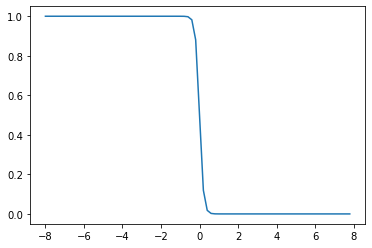

In [10]:
plot_sigmoid()